# Profiling NYC Collisions Data 


### Key Questions
- What fields are there and are they useful? 
- Are the fields missing data?
- Are there significant gaps in the data over time?
- Are there inconsistencies in the total number of people injured or killed and their respective breakdowns into motorist, pedestrian, and cyclist?
- Are many collisions missing location data? 
- Does 'location' match 'latititude' and 'longitude'?
- Are collision locations near NYC? 

### Data Sources
- Collision data obtained from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
 

In [1]:
from datetime import datetime
import math
import matplotlib.pyplot as plt
import pandas as pd
import pandahelper.reports as ph
import scipy.stats
from src import visualizations as viz

In [2]:
DATA_LOC = "data/raw/Collisions.csv"

In [3]:
data = pd.read_csv(
    DATA_LOC, dtype={"ZIP CODE": "object"}, low_memory=False,
)  # read_csv interprets zip code as mixed type

# Overview of DataFrame

In [4]:
ph.DataFrameProfile(data)

DataFrame-Level Info
----------------------  -------------
DF Shape                (1946954, 29)
Duplicated Rows         0

Series Name                    Data Type
-----------------------------  -----------
CRASH DATE                     object
CRASH TIME                     object
BOROUGH                        object
ZIP CODE                       object
LATITUDE                       float64
LONGITUDE                      float64
LOCATION                       object
ON STREET NAME                 object
CROSS STREET NAME              object
OFF STREET NAME                object
NUMBER OF PERSONS INJURED      float64
NUMBER OF PERSONS KILLED       float64
NUMBER OF PEDESTRIANS INJURED  int64
NUMBER OF PEDESTRIANS KILLED   int64
NUMBER OF CYCLIST INJURED      int64
NUMBER OF CYCLIST KILLED       int64
NUMBER OF MOTORIST INJURED     int64
NUMBER OF MOTORIST KILLED      int64
CONTRIBUTING FACTOR VEHICLE 1  object
CONTRIBUTING FACTOR VEHICLE 2  object
CONTRIBUTING FACTOR VEHICLE 3  obj

# Examining individual fields (columns)

In [5]:
collision_id_report = ph.SeriesProfile(data["COLLISION_ID"])
collision_id_report

COLLISION_ID Info
-------------------  -------
Data Type            int64
Count                1946954
Unique Values        1946954
Null Values          0

  Value    Count  % of total
-------  -------  ------------
4455765        1  0.00%
3274498        1  0.00%
3263458        1  0.00%
3268252        1  0.00%
3266859        1  0.00%
3261536        1  0.00%
3269886        1  0.00%
3262146        1  0.00%
3273046        1  0.00%
3273309        1  0.00%
3272894        1  0.00%
3260200        1  0.00%
3263260        1  0.00%
3262875        1  0.00%
3268122        1  0.00%
3262329        1  0.00%
3274417        1  0.00%
3266979        1  0.00%
3268134        1  0.00%
3267813        1  0.00%
3918002        1  0.00%
3916727        1  0.00%
3918527        1  0.00%
3916307        1  0.00%
4583167        1  0.00%

Statistic                             Value
-------------------------  ----------------
count                           1.94695e+06
min                            22
1%               

Collision_ID is the primary key according to the dataset dictionary. We confirm that all its values are unique.

In [6]:
time_report = ph.SeriesProfile(data["CRASH TIME"])
date_report = ph.SeriesProfile(data["CRASH DATE"])
time_report, date_report

(CRASH TIME Info
 -----------------  -------
 Data Type          object
 Count              1946954
 Unique Values      1440
 Null Values        0
 
 Value      Count  % of total
 -------  -------  ------------
 16:00      27287  1.40%
 17:00      26727  1.37%
 15:00      26625  1.37%
 18:00      24690  1.27%
 14:00      24437  1.26%
 13:00      22684  1.17%
 9:00       20495  1.05%
 12:00      20447  1.05%
 19:00      20415  1.05%
 16:30      19711  1.01%
 8:00       19045  0.98%
 14:30      18940  0.97%
 10:00      18894  0.97%
 0:00       18622  0.96%
 11:00      18510  0.95%
 17:30      18496  0.95%
 18:30      16497  0.85%
 20:00      16416  0.84%
 8:30       15967  0.82%
 13:30      15879  0.82%
 2:31          86  0.00%
 5:31          86  0.00%
 4:02          84  0.00%
 3:31          84  0.00%
 4:31          81  0.00%
 
 
 ,
 CRASH DATE Info
 -----------------  -------
 Data Type          object
 Count              1946954
 Unique Values      3794
 Null Values        0
 
 Value  

__There are no obvious issues with the time and  date info__
- There are no null values in CRASH TIME and CRASH DATE
- All 1440 minutes in a day are represented in time data
- Times tend to be rounded estimates. For example: 16:00 is more common that 4:31, which is unsurprising
- ~3800 unique dates correspond to ~10+ years of data (which is what we have)

In [7]:
loc_report = ph.SeriesProfile(data["LOCATION"])
lat_report = ph.SeriesProfile(data["LATITUDE"])
long_report = ph.SeriesProfile(data["LONGITUDE"])
loc_report, lat_report, long_report

(LOCATION Info
 ---------------  -------
 Data Type        object
 Count            1722744
 Unique Values    262432
 Null Values      224210
 
 Value                        Count  % of total
 -------------------------  -------  ------------
 (0.0, 0.0)                    3778  0.22%
 (40.861862, -73.91282)         685  0.04%
 (40.608757, -74.038086)        670  0.04%
 (40.696033, -73.98453)         646  0.04%
 (40.8047, -73.91243)           597  0.03%
 (40.6960346, -73.9845292)      587  0.03%
 (40.675735, -73.89686)         503  0.03%
 (40.7606005, -73.9643142)      474  0.03%
 (40.820305, -73.89083)         467  0.03%
 (40.798256, -73.82744)         462  0.03%
 (40.658577, -73.89063)         458  0.03%
 (40.7572323, -73.9897922)      456  0.03%
 (40.77077, -73.91727)          450  0.03%
 (40.604153, -74.05198)         440  0.03%
 (40.6757357, -73.8968533)      435  0.03%
 (40.6585778, -73.8906229)      418  0.02%
 (40.733536, -73.87035)         415  0.02%
 (40.7606, -73.96434)      

In [8]:
percent_missing_loc = sum(data["LOCATION"].isna()) / len(data)
percent_missing_loc

0.11515937202419779

__~11.5% of collisions are missing location data__
- LOCATION is just the tuple, (LATITUDE, LONGITUDE)
- Some lat-long coordinates are invalid. For example: (0, 0) or a latitiude of 43.3444 (max latitude), which is far from NYC

In [9]:
injured_report = ph.SeriesProfile(data["NUMBER OF PERSONS INJURED"])
pedestrian_injured_report = ph.SeriesProfile(data["NUMBER OF PEDESTRIANS INJURED"])
cyclist_injured_report = ph.SeriesProfile(data["NUMBER OF CYCLIST INJURED"])
motorist_injured_report = ph.SeriesProfile(data["NUMBER OF MOTORIST INJURED"])
injured_report, pedestrian_injured_report, cyclist_injured_report, motorist_injured_report

(NUMBER OF PERSONS INJURED Info
 --------------------------------  -------
 Data Type                         float64
 Count                             1946936
 Unique Values                     28
 Null Values                       18
 
   Value    Count  % of total
 -------  -------  ------------
       0  1525788  78.37%
       1   326681  16.78%
       2    61572  3.16%
       3    20117  1.03%
       4     7545  0.39%
       5     2950  0.15%
       6     1198  0.06%
       7      528  0.03%
       8      218  0.01%
       9      117  0.01%
      10       75  0.00%
      11       44  0.00%
      12       28  0.00%
      13       21  0.00%
      15       10  0.00%
      14        9  0.00%
      16        8  0.00%
      17        5  0.00%
      18        5  0.00%
      19        4  0.00%
      40        1  0.00%
      31        1  0.00%
      27        1  0.00%
      32        1  0.00%
      43        1  0.00%
 
 Statistic                         Value
 -------------------------  -

__A few observations (< 50) are missing the the total number of people injured.__

There are no missing values for the individual pedestrian, cyclist, and motorist injured fields

In [10]:
killed_report = ph.SeriesProfile(data["NUMBER OF PERSONS KILLED"])
pedestrian_killed_report = ph.SeriesProfile(data["NUMBER OF PEDESTRIANS KILLED"])
cyclist_killed_report = ph.SeriesProfile(data["NUMBER OF CYCLIST KILLED"])
motorist_killed_report = ph.SeriesProfile(data["NUMBER OF MOTORIST KILLED"])
killed_report, pedestrian_killed_report, cyclist_killed_report, motorist_killed_report

(NUMBER OF PERSONS KILLED Info
 -------------------------------  -------
 Data Type                        float64
 Count                            1946923
 Unique Values                    7
 Null Values                      31
 
   Value    Count  % of total
 -------  -------  ------------
       0  1944316  99.87%
       1     2526  0.13%
       2       65  0.00%
       3       11  0.00%
       4        3  0.00%
       8        1  0.00%
       5        1  0.00%
 
 Statistic                         Value
 -------------------------  ------------
 count                       1.94692e+06
 min                         0
 1%                          0
 5%                          0
 25%                         0
 50%                         0
 75%                         0
 95%                         0
 99%                         0
 max                         8
 median                      0
 mean                        0.00139399
 median absolute deviation   0
 standard deviation     

__A few observations (< 50) are missing the the total number of people killed.__

There are no missing values for the individual pedestrian, cyclist, and motorist killed fields

In [11]:
factor1_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 1"])
factor2_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 2"])
factor3_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 3"])
factor4_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 4"])
factor5_report = ph.SeriesProfile(data["CONTRIBUTING FACTOR VEHICLE 5"])
factor1_report, factor2_report, factor3_report, factor4_report, factor5_report

(CONTRIBUTING FACTOR VEHICLE 1 Info
 ------------------------------------  -------
 Data Type                             object
 Count                                 1941055
 Unique Values                         61
 Null Values                           5899
 
 Value                             Count  % of total
 ------------------------------  -------  ------------
 Unspecified                      675976  34.83%
 Driver Inattention/Distraction   383393  19.75%
 Failure to Yield Right-of-Way    114295  5.89%
 Following Too Closely            102899  5.30%
 Backing Unsafely                  72856  3.75%
 Other Vehicular                   60542  3.12%
 Passing or Lane Usage Improper    52232  2.69%
 Turning Improperly                48249  2.49%
 Passing Too Closely               47397  2.44%
 Fatigued/Drowsy                   47270  2.44%
 Unsafe Lane Changing              38258  1.97%
 Traffic Control Disregarded       33105  1.71%
 Driver Inexperience               29743  1.53%
 U

__The 'CONTRIBUTING FACTOR VEHICLE' fields seem to have some issues__
- "Unspecified" is the most common response
- They are not mutually exclusive and in some cases, difficult to differentiate. For example: 'Passing or Lane Usage Improper' vs 'Passing Too Closely'
- Without knowing more about the processes that generated these _'contributing factor'_ fields, it would be difficult to use them with confidence

In [12]:
vtype1_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 1"])
vtype2_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 2"])
vtype3_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 3"])
vtype4_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 4"])
vtype5_report = ph.SeriesProfile(data["VEHICLE TYPE CODE 5"])
vtype1_report, vtype2_report, vtype3_report, vtype4_report, vtype5_report

(VEHICLE TYPE CODE 1 Info
 --------------------------  -------
 Data Type                   object
 Count                       1935411
 Unique Values               1449
 Null Values                 11543
 
 Value                                  Count  % of total
 -----------------------------------  -------  ------------
 Sedan                                 517669  26.75%
 PASSENGER VEHICLE                     416206  21.50%
 Station Wagon/Sport Utility Vehicle   408924  21.13%
 SPORT UTILITY / STATION WAGON         180291  9.32%
 Taxi                                   48128  2.49%
 4 dr sedan                             40134  2.07%
 TAXI                                   31911  1.65%
 Pick-up Truck                          31786  1.64%
 VAN                                    25266  1.31%
 OTHER                                  22967  1.19%
 Box Truck                              22274  1.15%
 UNKNOWN                                19935  1.03%
 Bus                                

__Vehicle type categories are somewhat unclear__
- "Passenger vehicle" is one of the biggest categories. What does 'passenger vehicle' mean given that there are already categories for sedans and SUVs?

# Are there significant gaps in data collection over time?

Adding a datetime column to make temporal analysis easier

In [13]:
dt_format = "%m/%d/%Y %H:%M"
data["datetime"] = data["CRASH DATE"] + " " + data["CRASH TIME"]
data["datetime"] = data["datetime"].apply(lambda x: datetime.strptime(x, dt_format))

Examining daily collisions, injuries, and deaths to check to gaps in the data

In [14]:
daily_collisions = data.groupby(by=data["datetime"].dt.date)["COLLISION_ID"].count()
daily_injuries = data.groupby(by=data["datetime"].dt.date)[
    "NUMBER OF PERSONS INJURED"
].sum()
daily_deaths = data.groupby(by=data["datetime"].dt.date)[
    "NUMBER OF PERSONS KILLED"
].sum()

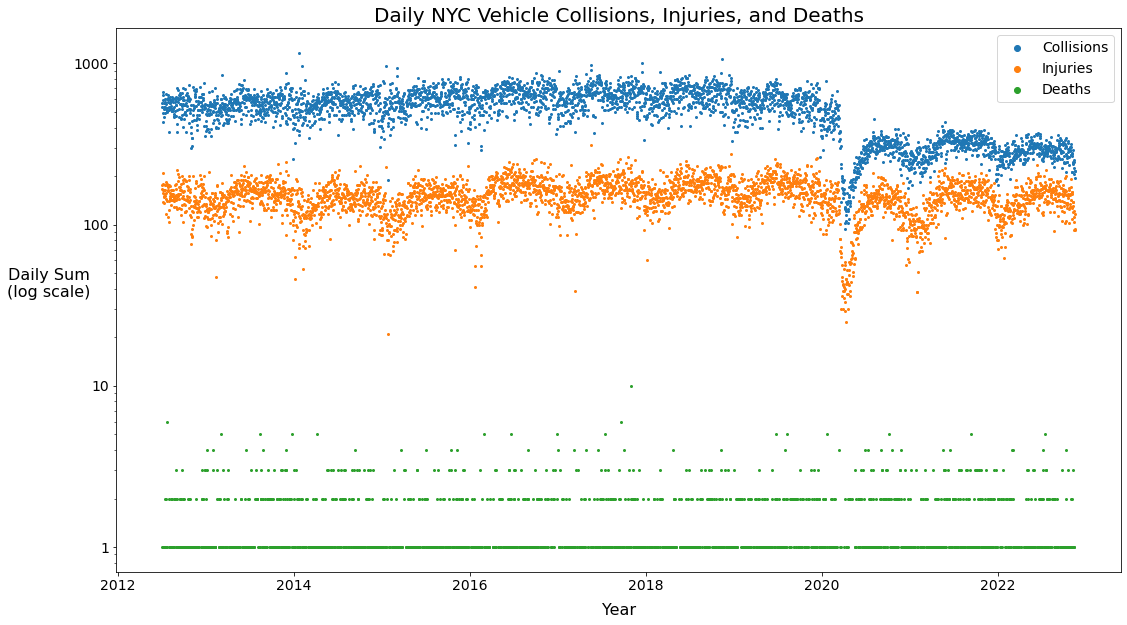

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.set_title("Daily NYC Vehicle Collisions, Injuries, and Deaths", fontsize=20)
ax.set_xlabel("Year", fontsize=16, labelpad=10)
ax.set_ylabel("Daily Sum\n(log scale)", fontsize=16, rotation=0, labelpad=25)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_yscale("log")
ax.yaxis.set_major_formatter("{x:.0f}")
ax.scatter(y=daily_collisions, x=daily_collisions.index, s=4)  # s is marker size
ax.scatter(y=daily_injuries, x=daily_injuries.index, s=4)
ax.scatter(y=daily_deaths, x=daily_deaths.index, s=4)
ax.legend(["Collisions", "Injuries", "Deaths"], fontsize=14, markerscale=3)
plt.show()

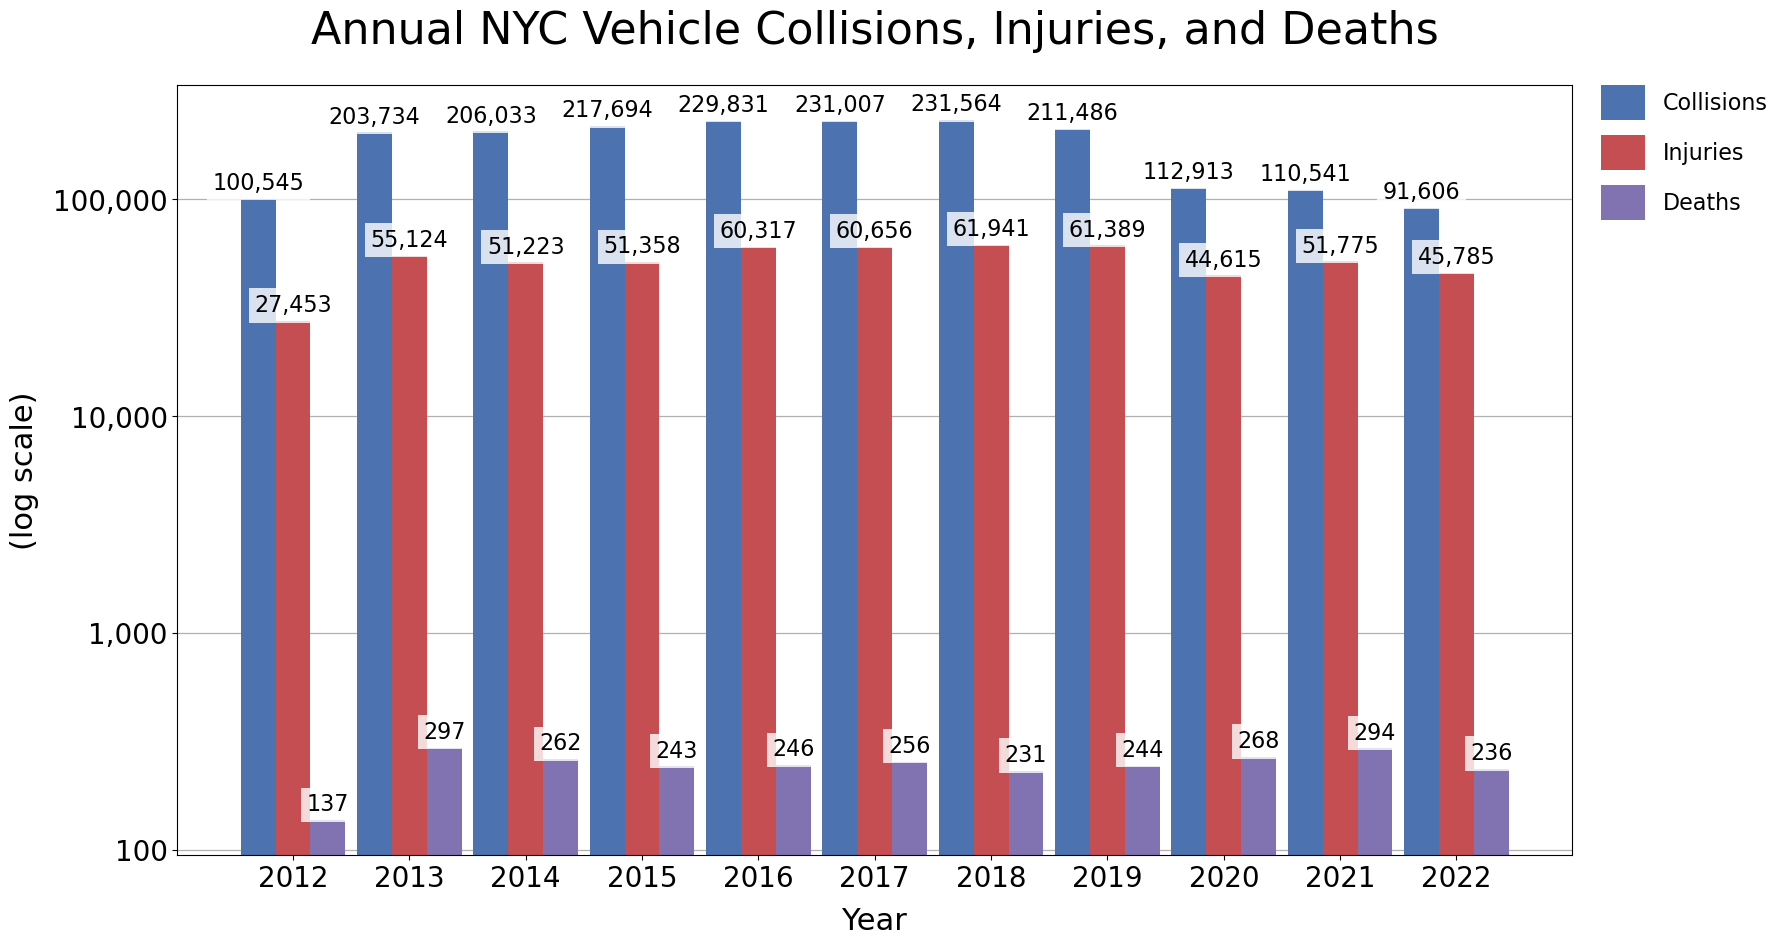

In [16]:
annual = pd.DataFrame()
annual["Collisions"] = data.groupby(by=data["datetime"].dt.year)["COLLISION_ID"].count()
annual["Injured"] = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS INJURED"
].sum()
annual["Deaths"] = data.groupby(by=data["datetime"].dt.year)[
    "NUMBER OF PERSONS KILLED"
].sum()
annual_labels = {
    "title": "Annual NYC Vehicle Collisions, Injuries, and Deaths",
    "y_label": "(log scale)",
    "x_label": "Year",
}
groups = [
    "Collisions",
    "Injuries",
    "Deaths",
]
viz.make_grouped_bar_chart(
    annual,
    **annual_labels,
    legend_labels=groups,
    colors=viz.CYCLE_COLORS,
    legend_handleheight=2.0,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    logscale=True,
    minor_ticks_off=True,
    ylabel_rotation="vertical",
    ylabel_pad=10,
    legend_bbox=(1.02, 0.9),
)

In [17]:
data["datetime"].min(), data["datetime"].max()

(Timestamp('2012-07-01 00:05:00'), Timestamp('2022-11-19 23:58:00'))

- __There does not appear to a significant gap in data collection going back to the start of the data set (July 2012)__
- __Fatal collisions are a small percentage of the dataset. Collisions with injuries are more common__
- __Let's limit the scope of analysis to 1 January 2013 to 31 December 2021, a 9 year span, for reproducibility purposes__

In [18]:
start = datetime(year=2013, month=1, day=1)
end = datetime(year=2022, month=1, day=1)
crashes = data[data["datetime"].between(start, end, inclusive="left")].copy()
crashes["datetime"].min(), crashes["datetime"].max()

(Timestamp('2013-01-01 00:01:00'), Timestamp('2021-12-31 23:57:00'))

# Does 'NUMBER OF PERSONS INJURED' match the separate 'INJURED' categories?

In [19]:
crashes["sum injured categories"] = (
    crashes["NUMBER OF PEDESTRIANS INJURED"]
    + crashes["NUMBER OF CYCLIST INJURED"]
    + crashes["NUMBER OF MOTORIST INJURED"]
)
num_mismatch = len(
    crashes[crashes["sum injured categories"] != crashes["NUMBER OF PERSONS INJURED"]]
)
num_mismatch

2745

In [20]:
num_mismatch / len(crashes)

0.0015642781554396704

There do appear to be ~2700 collisions (or < 0.2% of total collisions) where the 'NUMBER OF PERSONS INJURED' field does not match the sum of the distinct injured categories (pedestrian, cyclist, motorist)

In [21]:
total_injured = crashes["NUMBER OF PERSONS INJURED"].sum()
difference = (
    crashes["NUMBER OF PERSONS INJURED"].sum() - crashes["sum injured categories"].sum()
)
difference

2412.0

In [22]:
(difference / total_injured)

0.004839505776507932

- The cumulative discrepancy between the 'NUMBER OF PERSONS INJURED' field and the sum of the distinct injury fields (pedestrian, cyclist, motorist) is ~2400 injuries or < 0.5%
- __Given the relatively small difference, we will use the separate 'injury' fields in our analyses going forward__


# Does 'NUMBER OF PERSONS KILLED' match the separate 'KILLED' categories?

In [23]:
crashes["sum killed categories"] = (
    crashes["NUMBER OF PEDESTRIANS KILLED"]
    + crashes["NUMBER OF CYCLIST KILLED"]
    + crashes["NUMBER OF MOTORIST KILLED"]
)
len(crashes[crashes["sum killed categories"] != crashes["NUMBER OF PERSONS KILLED"]])

57

In [24]:
total_killed = crashes["NUMBER OF PERSONS KILLED"].sum()
difference_deaths = (
    crashes["NUMBER OF PERSONS KILLED"].sum() - crashes["sum killed categories"].sum()
)
difference_deaths

14.0

In [25]:
(difference_deaths / total_killed)

0.00598035027765912

- There are ~60 collisions with differences between the 'NUMBER OF PERSONS KILLED' field and the sum of the separate killed fields (pedestrian, cyclist, motorist). The 14 death discrepancy represents a small percent of the total deaths (< 0.6%)

- __Once again given the relatively small difference, we will use the separate 'killed' fields in our analyses going forward__

# Are many serious collisions missing location information? 

- We define _serious_ as a collision that results in injury or death. 
- Future analyses will tend to focus on serious collisions

In [26]:
crashes["serious_accident"] = (crashes["NUMBER OF PERSONS INJURED"] > 0) | (
    crashes["NUMBER OF PERSONS KILLED"] > 0
)
crashes["lat_long_missing"] = crashes["LOCATION"].isna()

In [27]:
(len(crashes) - crashes["lat_long_missing"].sum()) / len(crashes)

0.885378586656166

~89% of collisions have lat_long coordinates

In [28]:
pd.crosstab(
    index=crashes["lat_long_missing"],
    columns=crashes["serious_accident"],
    margins=True,
    normalize=True,
)

serious_accident,False,True,All
lat_long_missing,,,
False,0.697970,0.187409,0.885379
True,0.092150,0.022471,0.114621
All,0.790119,0.209881,1.000000


In [29]:
contingency_table = pd.crosstab(
    index=crashes["lat_long_missing"], columns=crashes["serious_accident"]
)
chi2_results = scipy.stats.chi2_contingency(contingency_table)
p_val = chi2_results[1]
p_val

6.3775179428329415e-59

In [30]:
# col, row indexing
percent_with_lat_long_that_are_serious = contingency_table[1][0] / (
    contingency_table[0][0] + contingency_table[1][0]
)
percent_with_lat_long_that_are_serious

0.21167111314215098

In [31]:
percent_missing_lat_long_that_are_serious = contingency_table[1][1] / (
    contingency_table[0][1] + contingency_table[1][1]
)
percent_missing_lat_long_that_are_serious

0.1960494784675198

In [32]:
percent_serious_missing_lat_long = contingency_table[1][1] / (
    contingency_table[1][0] + contingency_table[1][1]
)
percent_serious_missing_lat_long

0.1070678986367055

- The p-value of the Chi-squared test is ~0
- Using the Chi-squared test, we reject the null hypothesis that the percentage of collisions with injuries is the same for the population with lat-longs coordinates as for the population without lat-longs coordinates
- Approximately ~21% of the collisions that have lat-long coordinates are serious (with injuries or deaths)
- Approximately ~20% of the collisions that are missing coordinates are serious
- Serious collisions seem to be more likely to have lat-long coordinates with than less serious collisions
- ___The good news is that an analysis requiring lat-longs will not exclude data with a higher concentration of serious collisions___
- ___The bad news is that ~11% of serious accidents will be removed from the dataset by excluding collisions without lat-long coordinates___

A quick view of some serious accidents that are missing coordinates suggests that a more in-depth analysis could obtain approximate lat-long coordinates for some of the serious accidents based on other location data

In [33]:
serious_missing_location = crashes[
    (crashes["LOCATION"].isna()) & (crashes["serious_accident"] == True)
]
serious_missing_location[
    ["ON STREET NAME", "CROSS STREET NAME", "OFF STREET NAME"]
].head(20)

,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME
0,WHITESTONE EXPRESSWAY,20 AVENUE,NaN
17,MEEKER AVENUE,LORIMER STREET,NaN
33,KINGSLAND AVENUE,MEEKER AVENUE,NaN
36,THROGS NECK BRIDGE,NaN,NaN
82,OCEAN PARKWAY,NaN,NaN
282,CROSS BRONX EXPY RAMP,NaN,NaN
344,BRONX RIVER PARKWAY RAMP,NaN,NaN
384,LAYTON AVENUE,THROGMORTAN AVENUE,NaN
437,NEW ENGLAND THRUWAY,NaN,NaN
483,ROCKAWAY BOULEVARD,225 STREET,NaN


# Does 'LOCATION' match the individual 'LATITUDE' and 'LONGITUDE' fields?

In [34]:
def loc_string_to_tuple(s):
    """Helper function to convert strings in 'LOCATION' to numeric tuple"""
    s = str(s)  # to handle 'nan's without checking type
    if s == "nan":
        ret = (float("nan"), float("nan"))
    else:
        s_list = s.strip().split(",")
        ret = tuple(float(s.strip("()")) for s in s_list)
    return ret


def tuples_match(tup1, tup2):
    """Check for tuple equality given that values may be float('nan'). 
    float('nan') != float('nan'). Returns Boolean"""
    if math.isnan(tup1[0]):
        return all([math.isnan(x) for x in (tup1 + tup2)])
    else:
        return tup1 == tup2

In [35]:
location = crashes["LOCATION"].apply(loc_string_to_tuple)
lat_long = list(zip(crashes["LATITUDE"], crashes["LONGITUDE"]))
matches = [tuples_match(x[0], x[1]) for x in zip(location, lat_long)]
all(matches)

True

__'LOCATION' matches the individual 'LATITUDE' and 'LONGITUDE' fields__

# Are there obviously wrong lat-long coordinates (far outside NYC)?

In [36]:
NYC_WEST_LIMIT = -74.30  # west of Staten Island
NYC_EAST_LIMIT = -73.70  # east of Queens / Lakeville Rd.
NYC_SOUTH_LIMIT = 40.45  # south of Staten Island
NYC_NORTH_LIMIT = 40.95  # north of the Bronx
crashes["good_lat_long"] = (
    crashes["LONGITUDE"].between(NYC_WEST_LIMIT, NYC_EAST_LIMIT)
) & (crashes["LATITUDE"].between(NYC_SOUTH_LIMIT, NYC_NORTH_LIMIT))

In [37]:
with_lat_long_sum = crashes[~crashes["lat_long_missing"]]["good_lat_long"].count()
good_lat_long_sum = crashes[~crashes["lat_long_missing"]]["good_lat_long"].sum()
good_lat_long_sum / with_lat_long_sum

0.9985170548348582

In [38]:
with_lat_long_sum - good_lat_long_sum

2304

~99.9% (or all but ~2300) of the collisions that have coordinates, have coordinates that are in vicinity of NYC. 

# Conclusions

- The data contains time, location (in most cases), and the number of people injured or killed in automobile collisions dating back to 2012
- There do not appear to be any significant gaps in data collection going back to 2012
- There are some minor inconsistencies betweeen the total number of people injured or killed and their respective breakdown into pedestrian, cyclist, and motorist categories. We will be using the distinct categories going forward rather than the provided sum. The sum injured and killed fields can be recomputed from the separate categories
- ~11.5% of collisions are missing location data
- The 'LOCATION' field matches "LATITUDE' and 'LONGITUDE' with no inconsistencies 
- ~99.9% of collisions with location data have coordinates that correspond to the NYC area